In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a Spark Session

In [ ]:
spark = SparkSession.builder.appName("MonumentDataAnalytics").getOrCreate()

25/04/16 16:34:32 WARN Utils: Your hostname, victus resolves to a loopback address: 127.0.1.1; using 10.1.216.114 instead (on interface wlo1)
25/04/16 16:34:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 16:34:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
data = spark.read.csv("India-Tourism-Statistics-2021-Table.csv", header=True, inferSchema=True)

data.head(10)

[Row(Circle='Agra', Name of the Monument ='Taj Mahal', Domestic-2019-20=4429710, Foreign-2019-20=645415, Domestic-2020-21=1259892, Foreign-2020-21=9034, % Growth 2021-21/2019-20-Domestic='-71.56', % Growth 2021-21/2019-20-Foreign='-98.6'),
 Row(Circle='Agra', Name of the Monument ='Agra Fort', Domestic-2019-20=1627154, Foreign-2019-20=386522, Domestic-2020-21=371242, Foreign-2020-21=2810, % Growth 2021-21/2019-20-Domestic='-77.18', % Growth 2021-21/2019-20-Foreign='-99.27'),
 Row(Circle='Agra', Name of the Monument ='Fatehpur Sikri', Domestic-2019-20=454376, Foreign-2019-20=184751, Domestic-2020-21=107835, Foreign-2020-21=574, % Growth 2021-21/2019-20-Domestic='-76.27', % Growth 2021-21/2019-20-Foreign='-99.69'),
 Row(Circle='Agra', Name of the Monument ='Akbar Tomb Sikandra', Domestic-2019-20=229270, Foreign-2019-20=19625, Domestic-2020-21=99509, Foreign-2020-21=321, % Growth 2021-21/2019-20-Domestic='-56.6', % Growth 2021-21/2019-20-Foreign='-98.36'),
 Row(Circle='Agra', Name of the 

# Data preprocessing

In [ ]:
# 1. Data Cleaning & Transformation
data = data.na.drop()

# 2. Feature Engineering
# Create a vector assembler to combine relevant features
features = ["Domestic-2019-20", "Foreign-2019-20"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)



25/04/16 16:34:39 WARN Instrumentation: [5e3511b8] regParam is zero, which might cause numerical instability and overfitting.


Root Mean Squared Error (RMSE): 39686.63198260554
Coefficients: [0.23497159602669457,0.16250248405417805]
Intercept: 14689.957907868997
Predicted Domestic Visitors in 2020-21: 2034839.594671269


# Model training

In [ ]:
# 3. Model Selection & Training
# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Domestic-2020-21")

# Split the data into training and testing sets
(trainingData, testData) = data.randomSplit([0.8, 0.2])

# Train the model on the training data
lrModel = lr.fit(trainingData)

# Model evaluation

In [ ]:
# 4. Model Evaluation
# Make predictions on the test data
predictions = lrModel.transform(testData)

# Evaluate the model using a RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Domestic-2020-21", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 5. Model Interpretation & Insights
# Print the coefficients and intercept of the model
print(f"Coefficients: {lrModel.coefficients}")
print(f"Intercept: {lrModel.intercept}")

# Model predictions

In [ ]:
newRow = spark.createDataFrame([
    (7632914, 1394635)
], ["Domestic-2019-20", "Foreign-2019-20"])

newRow = assembler.transform(newRow)
prediction = lrModel.transform(newRow).select("prediction")
print(f"Predicted Domestic Visitors in 2020-21: {prediction.first().prediction}")

In [5]:
# RDD Operations Convert the DataFrame to an RDD
rdd = data.rdd

In [6]:
#  Calculate the total foreign visitors in 2020-21
total_foreign_2020_21 = rdd.map(lambda x: x["Foreign-2020-21"]).sum()
print(f"Total Foreign Visitors in 2020-21: {total_foreign_2020_21}")

Total Foreign Visitors in 2020-21: 415859


In [7]:
# Find the city with the highest number of monuments
city_monument_count = data.groupBy("Circle").count().orderBy("count", ascending=False).limit(1).toPandas()
print("City with the Highest Number of Monuments:")
print(city_monument_count)

City with the Highest Number of Monuments:
   Circle  count
0  Mumbai     13


In [8]:
# Calculate the total number of domestic visitors in 2019-20
total_domestic_2019_20 = rdd.map(lambda x: x["Domestic-2019-20"]).sum()
print(f"Total Domestic Visitors in 2019-20: {total_domestic_2019_20}")



Total Domestic Visitors in 2019-20: 43607075


In [9]:
import matplotlib.pyplot as plt


# Calculate the average foreign visitors in 2019-20
avg_foreign_2019_20 = rdd.map(lambda x: x["Foreign-2019-20"]).mean()
# # Create a histogram of domestic visitors in 2019-20
# plt.hist(data.toPandas()["Domestic-2019-20"], bins=50)
# plt.title("Distribution of Domestic Visitors in 2019-20")
# plt.xlabel("Number of Visitors")
# plt.ylabel("Frequency")
# plt.show()
print(f"Average Foreign Visitors in 2019-20: {avg_foreign_2019_20}")


Average Foreign Visitors in 2019-20: 19142.784722222234


Top 5 Monuments with Highest Domestic Visitors in 2019-20:
mattancherry Palace Museum Kochi: 300465
Western Group of Temples, Khajuraho: 244995
Warangal: 92690
Upper Fort Aguada: 837898
Undavalli caves: 109307
Top 5 Monuments with Highest Domestic Visitors in 2020-21:
mattancherry Palace Museum Kochi: 23026
Western Group of Temples, Khajuraho: 128515
Warangal: 64339
Upper Fort Aguada: 379726
Undavalli caves: 52924


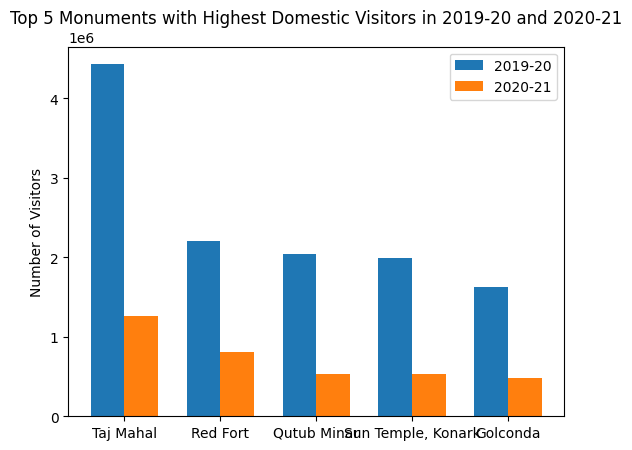

In [10]:
import numpy as np
from pyspark.sql.functions import col


# Calculate the top 5 monuments with the highest domestic visitors in 2019-20
top_5_monuments = rdd.map(lambda x: (x["Name of the Monument "], x["Domestic-2019-20"])).sortByKey(ascending=False).take(5)
print("Top 5 Monuments with Highest Domestic Visitors in 2019-20:")
for monument, visitors in top_5_monuments:
    print(f"{monument}: {visitors}")

# Calculate the top 5 monuments with the highest domestic visitors in 2020-21
top_5_monuments = rdd.map(lambda x: (x["Name of the Monument "], x["Domestic-2020-21"])).sortByKey(ascending=False).take(5)
print("Top 5 Monuments with Highest Domestic Visitors in 2020-21:")
for monument, visitors in top_5_monuments:
    print(f"{monument}: {visitors}")

# Get the top 5 monuments with highest domestic visitors in 2019-20 and 2020-21
top_5_monuments_2019_20 = data.select("Name of the Monument ", "Domestic-2019-20").orderBy(col("Domestic-2019-20").desc()).limit(5).toPandas()
top_5_monuments_2020_21 = data.select("Name of the Monument ", "Domestic-2020-21").orderBy(col("Domestic-2020-21").desc()).limit(5).toPandas()

# Create a double bar chart
x = np.arange(len(top_5_monuments_2019_20))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, top_5_monuments_2019_20["Domestic-2019-20"], width, label='2019-20')
rects2 = ax.bar(x + width/2, top_5_monuments_2020_21["Domestic-2020-21"], width, label='2020-21')

ax.set_ylabel('Number of Visitors')
ax.set_title('Top 5 Monuments with Highest Domestic Visitors in 2019-20 and 2020-21')
ax.set_xticks(x)
ax.set_xticklabels(top_5_monuments_2019_20["Name of the Monument "])

ax.legend()

plt.show()

In [11]:
# Calculate the top 5 monuments with the highest foreign visitors in 2019-20
top_5_monuments = rdd.map(lambda x: (x["Name of the Monument "], x["Foreign-2019-20"])).sortByKey(ascending=False).take(5)
print("Top 5 Monuments with Highest Foreign Visitors in 2019-20:\n\n")
for monument, visitors in top_5_monuments:
    print(f"{monument}: {visitors}")

# Calculate the top 5 monuments with the highest foreign visitors in 2020-21
top_5_monuments = rdd.map(lambda x: (x["Name of the Monument "], x["Foreign-2020-21"])).sortByKey(ascending=False).take(5)
print("Top 5 Monuments with Highest Foreign Visitors in 2020-21:")
for monument, visitors in top_5_monuments:
    print(f"{monument}: {visitors}")

Top 5 Monuments with Highest Foreign Visitors in 2019-20:


mattancherry Palace Museum Kochi: 79355
Western Group of Temples, Khajuraho: 41741
Warangal: 277
Upper Fort Aguada: 8104
Undavalli caves: 494
Top 5 Monuments with Highest Foreign Visitors in 2020-21:
mattancherry Palace Museum Kochi: 177
Western Group of Temples, Khajuraho: 275
Warangal: 54
Upper Fort Aguada: 340
Undavalli caves: 89


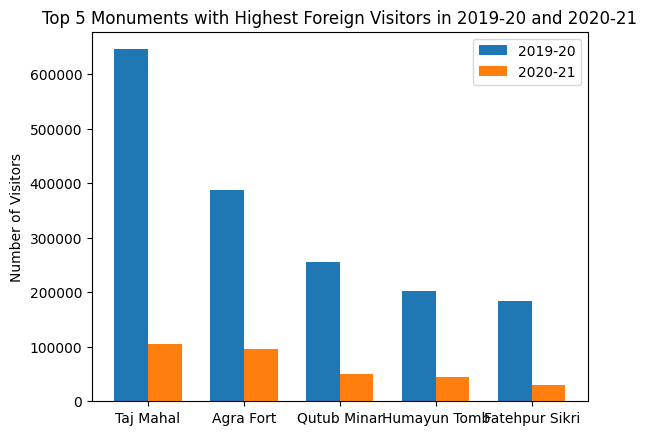

In [12]:
import numpy as np

# Get the top 5 monuments with highest foreign visitors in 2019-20 and 2020-21
top_5_monuments_2019_20 = data.select("Name of the Monument ", "Foreign-2019-20").orderBy(col("Foreign-2019-20").desc()).limit(5).toPandas()
top_5_monuments_2020_21 = data.select("Name of the Monument ", "Foreign-2020-21").orderBy(col("Foreign-2020-21").desc()).limit(5).toPandas()

# Create a double bar chart
x = np.arange(len(top_5_monuments_2019_20))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, top_5_monuments_2019_20["Foreign-2019-20"], width, label='2019-20')
rects2 = ax.bar(x + width/2, top_5_monuments_2020_21["Foreign-2020-21"], width, label='2020-21')

ax.set_ylabel('Number of Visitors')
ax.set_title('Top 5 Monuments with Highest Foreign Visitors in 2019-20 and 2020-21')
ax.set_xticks(x)
ax.set_xticklabels(top_5_monuments_2019_20["Name of the Monument "])

ax.legend()

plt.show()

In [13]:
most_visited_foreign_2020_21 = rdd.map(lambda x: (x["Name of the Monument "], x["Foreign-2020-21"])).sortByKey(ascending=False).take(1)
print("Most Visited Monument by Foreigners in 2020-21:")
for monument, visitors in most_visited_foreign_2020_21:
    print(f"{monument}: {visitors}")



Most Visited Monument by Foreigners in 2020-21:
mattancherry Palace Museum Kochi: 177


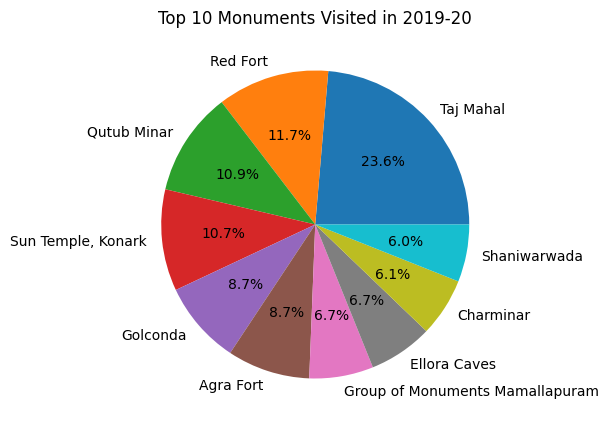

In [14]:

# Get the top 10 monuments with the most visitors in 2019-20
top_monuments = data.toPandas().sort_values(by='Domestic-2019-20', ascending=False).head(10)

# Create a pie chart
plt.figure(figsize=(7,5))
plt.pie(top_monuments['Domestic-2019-20'], labels = top_monuments['Name of the Monument '], autopct='%1.1f%%')
plt.title("Top 10 Monuments Visited in 2019-20")
plt.show()

In [15]:
#  Find the city which has suffered a great drop in tourism in the year 2020-21 due to pandemic as compared to 2019-20
city_drop = rdd.map(lambda x: (x["Circle"], x["Foreign-2019-20"] - x["Foreign-2020-21"])).sortByKey(ascending=False).take(1)
print("City with the Greatest Drop in Tourism in 2020-21:")
for circle, drop in city_drop:
    print(f"{circle}: {drop}")


City with the Greatest Drop in Tourism in 2020-21:
Vadodara: 1867


In [16]:
# Most loved monument from both years combined
most_loved_monument = rdd.map(lambda x: (x["Name of the Monument "], x["Domestic-2019-20"] + x["Foreign-2019-20"] + x["Domestic-2020-21"] + x["Foreign-2020-21"])).sortByKey(ascending=False).take(1)
print("Most Loved Monument from Both Years:")
for monument, visitors in most_loved_monument:
    print(f"{monument}: {visitors}")

Most Loved Monument from Both Years:
mattancherry Palace Museum Kochi: 403023


In [ ]:

spark.stop()